In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# from pandas.conftest import axis_1
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

In [33]:
myFil_blank_sky = FilReader('./data/blank_sky.fil')
myFil_calibrator_source = FilReader('./data/calibrator_source.fil')
# myFil_blank_sky
myFil_calibrator_source

In [34]:
Pretty(myFil_blank_sky.header)

Header(
    filename='./data/blank_sky.fil',
    data_type='filterbank',
    nchans=1024,
    foff=-0.390625,
    fch1=800.0,
    nbits=32,
    tsamp=0.00032768,
    tstart=60638.34381999473,
    nsamples=30518,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (68.75000238, 45.02999878)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='CHIME',
    backend='CHIME',
    source='Fake',
    frame='topocentric',
    ibeam=1,
    nbeams=1,
    dm=0.0,
    period=0,
    accel=0,
    signed=0,
    rawdatafile='test.dat',
    stream_info=StreamInfo(
        entries=[
            FileInfo(
                filename='./data/blank_sky.fil',
                hdrlen=414,
                datalen=125001728,
                nsamples=30518,
                tstart=60638.34381999473,
                tsamp=0.00032768
            )
        ]
    )
)

## Part 1 (Rough)

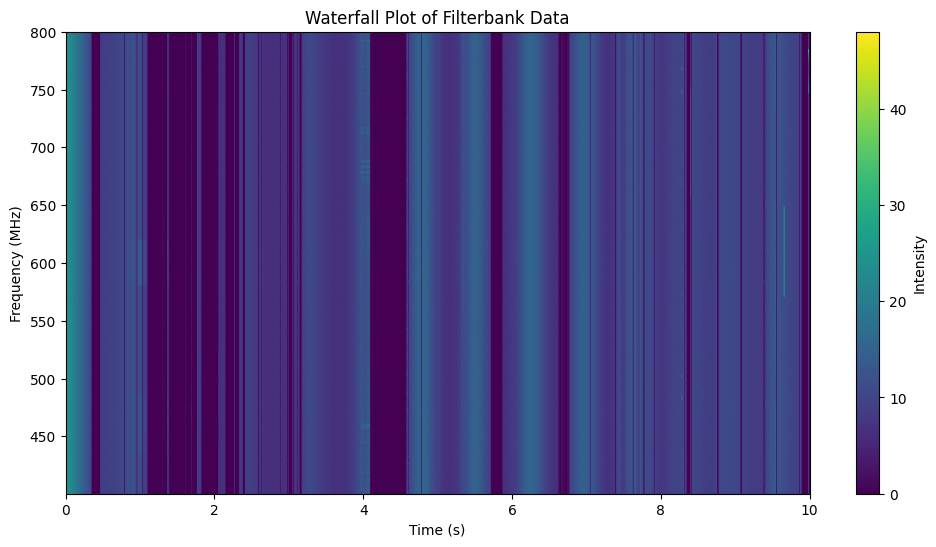

In [35]:
# Specify your filterbank file
filename = '../data/blank_sky.fil'
# filename = './data/calibrator_source.fil'
fil = FilReader(filename)

# Read all samples (or choose a subset)
n_samples = fil.header.nsamples
fb = fil.read_block(0, n_samples)  # fb is a FilterbankBlock object

# Extract the underlying NumPy array
if hasattr(fb, 'data'):
    data_array = fb.data
else:
    data_array = np.array(fb)

# Compute frequency axis using header info
nchans = fil.header.nchans
fch1 = fil.header.fch1
foff = fil.header.foff
freqs = fch1 + np.arange(nchans) * foff

# Create a waterfall (dynamic spectrum) plot

#TODO: Turn this into subplots showing both blank sky and calibration files next to eachother

plt.figure(figsize=(12, 6))
# fig, (ax1, ax2) = plt.subplots()
plt.imshow(data_array.T, aspect='auto', origin='lower',
           extent=[0, n_samples * fil.header.tsamp, freqs[-1], freqs[0]])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.title('Waterfall Plot of Filterbank Data')
plt.colorbar(label='Intensity')
plt.show()

## Part 1

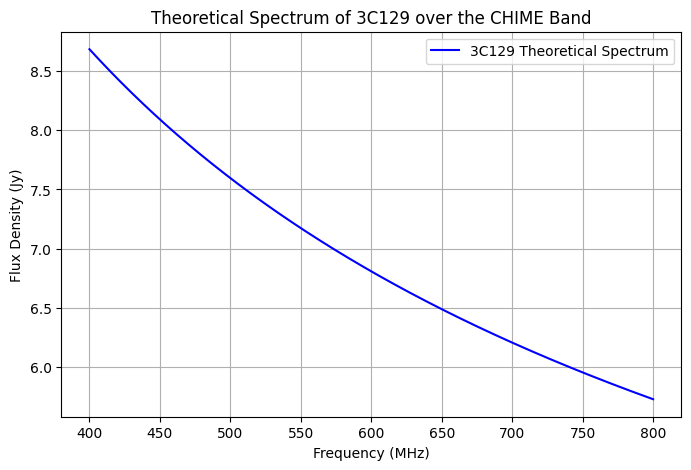

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from blimpy import Waterfall

# =============================================================================
# 1. Plot the theoretical spectrum of calibrator 3C129 over the CHIME band
# -----------------------------------------------------------------------------
# 3C129 is given with S400 = 8.684 Jy at 400 MHz and a spectral index α = -0.6.
# The spectrum is assumed to follow: S(ν) = S400 * (ν/400 MHz)^α.
# We assume the CHIME band roughly spans 400 to 800 MHz.
# =============================================================================

def theoretical_spectrum(freq, S400=8.684, alpha=-0.6):
    """Return the flux density in Jy for a given frequency in MHz."""
    return S400 * (freq / 400.0) ** alpha

# Define the CHIME frequency band (in MHz)
chime_freqs = np.linspace(400, 800, 1024)  # 1024 channels across the band

# Calculate the theoretical flux density at each frequency
flux_theory = theoretical_spectrum(chime_freqs)

# Plot the theoretical spectrum
plt.figure(figsize=(8, 5))
plt.plot(chime_freqs, flux_theory, label='3C129 Theoretical Spectrum', color='blue')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux Density (Jy)')
plt.title('Theoretical Spectrum of 3C129 over the CHIME Band')
plt.legend()
plt.grid(True)
plt.show()



## Part 2

Filterbank header information:
  First channel frequency: 800.0 MHz
  Channel spacing: -0.390625 MHz
  Number of channels: 1024
(1024,)
(1024,)


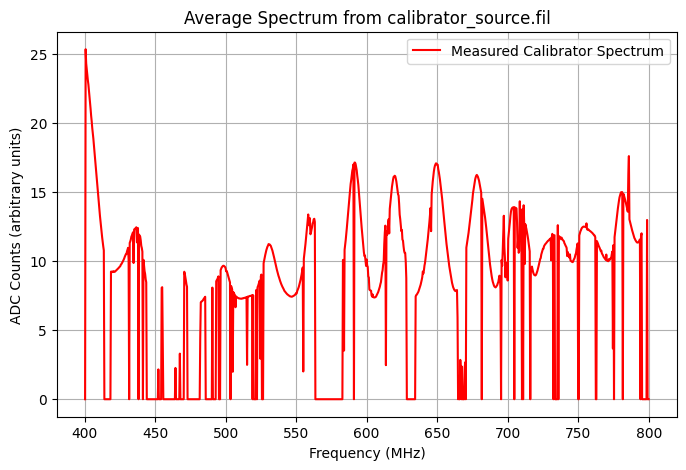

In [37]:
%matplotlib inline
# -----------------------------------------------------------------------------
# 2. Load the calibrator filterbank file using sigpyproc and compute its average spectrum
# -----------------------------------------------------------------------------
# Replace 'calibrator_source.fil' with the path to your .fil file.
filename = '../data/calibrator_source.fil'
fil = FilReader(filename)
header = fil.header

# Extract frequency-related information from the header
# Typically the header contains:
#   fch1  : frequency of the first channel (MHz)
#   foff  : channel spacing (MHz) [this may be negative]
#   nchans: total number of frequency channels
fch1   = fil.header.fch1
foff   = fil.header.foff
nchans = fil.header.nchans

# Construct the frequency axis. (If foff is negative, the channels are in reverse order.)
freq_axis = fch1 + np.arange(nchans) * foff
if foff < 0:
    freq_axis = freq_axis[::-1]

print("Filterbank header information:")
print(f"  First channel frequency: {fch1} MHz")
print(f"  Channel spacing: {foff} MHz")
print(f"  Number of channels: {nchans}")

# Read in the data.
# Depending on your file size, this may read all data into memory.
# We assume the data shape is (n_time, n_freq)
fb = fil.read_block(0, n_samples)  # fb is a FilterbankBlock object

# Extract the underlying NumPy array
if hasattr(fb, 'data'):
    data = fb.data
else:
    data = np.array(fb)

# Compute the average spectrum by averaging over the time axis.
avg_spectrum = np.mean(data, axis=1)
print(avg_spectrum.shape)
print(freq_axis.shape)

# Plot the measured average spectrum (in ADC counts or arbitrary units)
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, avg_spectrum, label='Measured Calibrator Spectrum', color='red')
plt.xlabel('Frequency (MHz)')
plt.ylabel('ADC Counts (arbitrary units)')
plt.title('Average Spectrum from calibrator_source.fil')
plt.legend()
plt.grid(True)
plt.show()

Part 2 (Optional) - Compare theoretical spectrum to measured spectrum

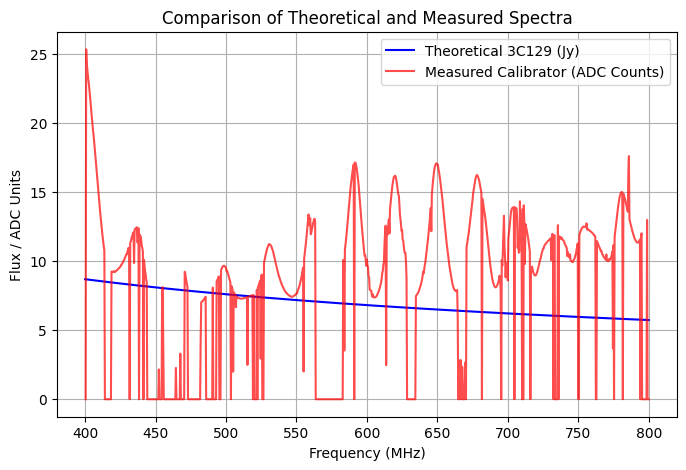

In [38]:
# =============================================================================
# 3. (Optional) Compare the theoretical spectrum to the measured spectrum'
# -----------------------------------------------------------------------------
# You might wish to overlay the two spectra. However, note that the measured
# data is in raw ADC counts and has not yet been calibrated to Jy.
# =============================================================================

# For an overlay, we can replot both on the same figure.
plt.figure(figsize=(8, 5))
plt.plot(chime_freqs, flux_theory, label='Theoretical 3C129 (Jy)', color='blue')
plt.plot(freq_axis, avg_spectrum, label='Measured Calibrator (ADC Counts)', color='red', alpha=0.7)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux / ADC Units')
plt.title('Comparison of Theoretical and Measured Spectra')
plt.legend()
plt.grid(True)
plt.show()


## Discussion of any odd features goes here.....

## Part 3 - Compute the transfer function

Header info:
  fch1   = 800.0 MHz
  foff   = -0.390625 MHz
  nchans = 1024


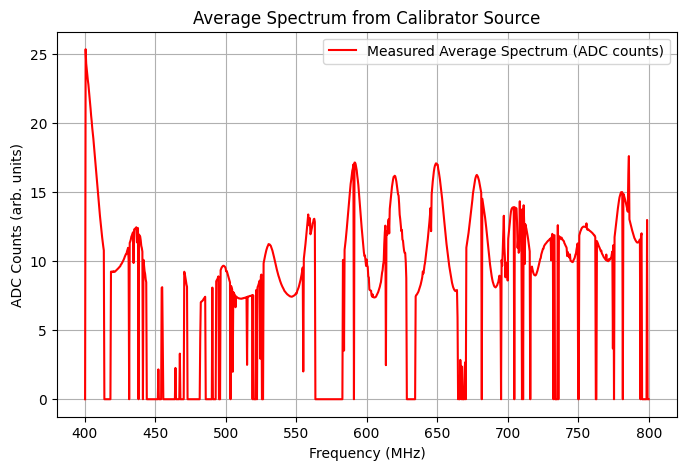

/tmp/ipykernel_8217/2739990561.py:74: RuntimeWarning: divide by zero encountered in divide
  transfer_function = theo_flux / avg_spectrum


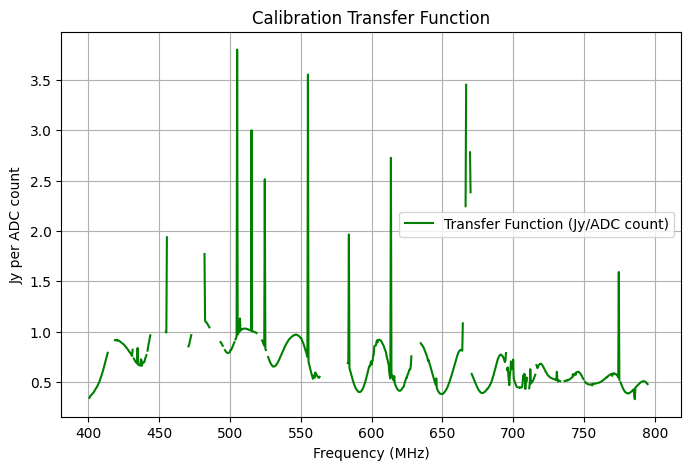

/tmp/ipykernel_8217/2739990561.py:91: RuntimeWarning: invalid value encountered in multiply
  data_calibrated = data * transfer_function[:, None]


(1024, 30518)


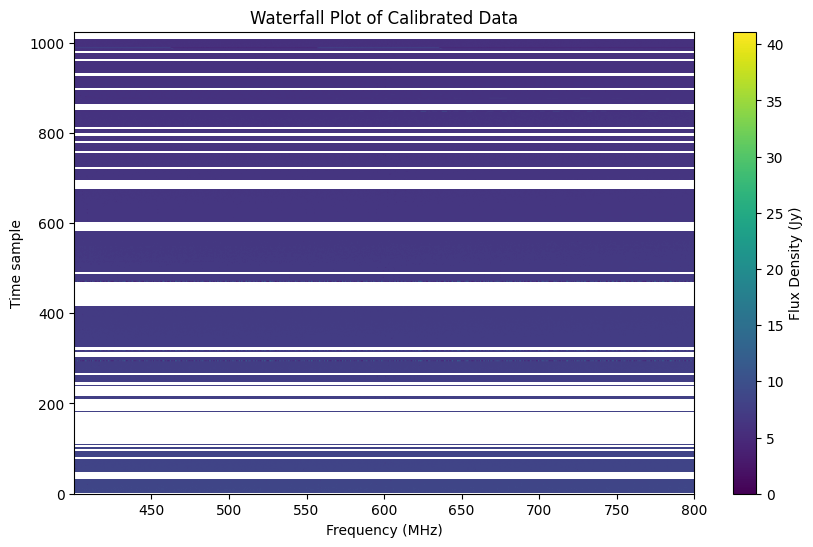

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sigpyproc.readers import FilReader

# -----------------------------------------------------------------------------
# 1. Define the theoretical spectrum of 3C129
# -----------------------------------------------------------------------------
# 3C129 has S400 = 8.684 Jy at 400 MHz with a spectral index α = -0.6.
# Its flux density as a function of frequency is:
#     S(ν) = 8.684 * (ν / 400)^(-0.6)   [Jy]
def theoretical_flux(nu, S400=8.684, alpha=-0.6):
    return S400 * (nu / 400.0) ** alpha

# -----------------------------------------------------------------------------
# 2. Load the calibrator filterbank file using sigpyproc
# -----------------------------------------------------------------------------
# Replace 'calibrator_source.fil' with the path to your file.
filename = '../data/calibrator_source.fil'
fil = FilReader(filename)
header = fil.header

# Extract frequency-related information from the header.
# fch1: frequency of the first channel (MHz)
# foff: channel spacing (MHz) -- note that this may be negative.
# nchans: number of frequency channels.
fch1   = fil.header.fch1
foff   = fil.header.foff
nchans = fil.header.nchans

# Construct the frequency axis.
freq_axis = fch1 + np.arange(nchans) * foff
# If foff is negative, channels are in reverse order; flip them.
if foff < 0:
    freq_axis = freq_axis[::-1]

print("Header info:")
print(f"  fch1   = {fch1} MHz")
print(f"  foff   = {foff} MHz")
print(f"  nchans = {nchans}")

# -----------------------------------------------------------------------------
# 3. Read in the data and compute the average (raw) spectrum.
# -----------------------------------------------------------------------------
# The data is assumed to have shape (n_time, n_freq).
fb = fil.read_block(0, n_samples)  # fb is a FilterbankBlock object

# Extract the underlying NumPy array
if hasattr(fb, 'data'):
    data = fb.data
else:
    data = np.array(fb)
# Compute the average spectrum over time (raw ADC counts).
avg_spectrum = np.mean(data, axis=1)

# Plot the raw (average) spectrum from the calibrator file.
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, avg_spectrum, color='red', label='Measured Average Spectrum (ADC counts)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('ADC Counts (arb. units)')
plt.title('Average Spectrum from Calibrator Source')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 4. Compute the transfer function (calibration factor)
# -----------------------------------------------------------------------------
# We compute the theoretical flux at each frequency channel.
theo_flux = theoretical_flux(freq_axis)

# Compute the calibration factor for each frequency channel.
# (Jy per ADC count) = (theoretical flux in Jy) / (measured average ADC counts)
# This transfer function assumes that the average ADC counts are proportional to flux.
transfer_function = theo_flux / avg_spectrum

# Optionally, you can inspect or plot the transfer function:
plt.figure(figsize=(8, 5))
plt.plot(freq_axis, transfer_function, color='green', label='Transfer Function (Jy/ADC count)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Jy per ADC count')
plt.title('Calibration Transfer Function')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 5. Apply the transfer function to calibrate the full data set.
# -----------------------------------------------------------------------------
# Multiply each frequency channel by its corresponding factor.
# data has shape (n_time, n_freq) and transfer_function is (n_freq,); broadcasting applies.
data_calibrated = data * transfer_function[:, None]
print(data.shape)
# -----------------------------------------------------------------------------
# 6. Create a waterfall plot of the calibrated data
# -----------------------------------------------------------------------------
# Here we plot the calibrated data as a function of time (y-axis) and frequency (x-axis).
plt.figure(figsize=(10, 6))
# Using imshow; we set 'origin' so that the lowest time index is at the bottom.
plt.imshow(data_calibrated, aspect='auto', origin='lower',
           extent=[freq_axis[0], freq_axis[-1], 0, data_calibrated.shape[0]])
plt.colorbar(label='Flux Density (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time sample')
plt.title('Waterfall Plot of Calibrated Data')
plt.show()

# -----------------------------------------------------------------------------
# 7. Discussion of the results:
# -----------------------------------------------------------------------------
# After calibrating, inspect the waterfall plot.
# - Does the flux appear smooth along frequency?
# - Are there frequency channels or time segments that show anomalous behavior
#   (spikes, dropouts, or other "odd features")?
#
# In many real data sets, you might see:
#   - Some channels affected by RFI (radio frequency interference),
#   - Drops or jumps in the flux level due to instrumental effects.
#
# You can print or plot additional diagnostics to further inspect these features.


In [40]:
print(transfer_function[:100])

[       inf 0.34249633 0.356771   0.36283223 0.36819424 0.37483795
 0.37979313 0.38692436 0.39297394 0.40105256 0.4107415  0.42055133
 0.42858057 0.43889869 0.44715334 0.45614429 0.46758106 0.47735623
 0.48999489 0.50355297 0.51820867 0.53482346 0.55050393 0.567827
 0.58512527 0.60338642 0.62249244 0.64426715 0.66419284 0.68712098
 0.7083563  0.72846191 0.74984995 0.7705387  0.79042377        inf
        inf        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf 0.91518844
 0.91399203 0.91684055 0.91657023 0.91031505 0.91506305 0.91188277
 0.91242783 0.90815249 0.90407226 0.9000659  0.89540241 0.89070825
 0.8866633  0.88217651 0.8771224  0.87256776 0.86833638 0.85845766
 0.85465144 0.84779738 0.84129839 0.83409641 0.82626606 0.81834985
 0.80858379 0.80159889 0.79339138 0.79174924 0.77810221 0.76764558
 0.75814011 0.82052943        inf 0.73329371 0.72562072 0.71652363
 0.70369872 0.6978349  0.69006029 0.68425075 0.83809072 0.672607

## Part 2: Calibrator Source Average Spectrum

Now let's plot the average spectrum of the calibrator source and compare to the theoretical spectrum. We first need to compute the average spectrum given the files read in initially using sigpyproc. After that, we can make a simple plot with the same axes as the theoretical spectrum above.

***Don't use this, it is repeated in the correct way in the next sequence of cells***

In [42]:
#NOTE: Don't use this cell! => It reverses the frequency axis which is the incorrect thing to do....

#define a header object for calibrator source file
calibrator_source_header = calibrator_source_Fil.header

#Extract frequency info from the header
fch1 = calibrator_source_header.fch1   #frequency of the first channel
foff = calibrator_source_header.foff   #channel spacing (negative means channels in reverse order)
nchans = calibrator_source_header.nchans #total number of channels

#print out some of the header results for reference
print()
print(f"Filterbank header info:")
print(f" Channel spacing: {foff} MHz")
print(f" First channel frequncy: {fch1} MHz")

#Construct frequency axis using header info
freq_axis = fch1 + np.arange(nchans)*foff
if foff < 0:
    freq_axis = freq_axis[::-1] #reverse axis if in reverse order

#compute the filterbank object statistics
calibrator_source_Fil.compute_stats()

#use the results above to plot the average spectrum
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_title("Calibrator Source 3C 129 Average Spectrum")
# ax.plot(freq_axis, calibrator_source_Fil.chan_stats.mean)
# ax.set_xlabel("Frequency (MHz)")
# ax.set_ylabel("ADC Counts")
# ax.grid(True)

NameError: name 'calibrator_source_Fil' is not defined

In [ ]:
#IF WANTIGN TO RUN THINGS WITHOUT THE RFI REMOVAL
# fb = calibrator_source_Fil.read_block(0,
#                                       calibrator_source_Fil.header.nsamples,
#                                       calibrator_source_Fil.header.fch1,
#                                       calibrator_source_Fil.header.nchans
#                                       )

# if hasattr(fb, 'data'):
#     data = fb.data
# else:
#     data = np.array(fb)
